In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
import pandas as pd
import numpy as np

# 선형회귀를 이용한 초미세먼지 / 천식 환자 수 예측

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1. 데이터 불러오기
asthma_df = pd.read_excel('Asthma_top30_Sum_removed_outliers.xlsx',
                          index_col=0, parse_dates=True)
dust_df   = pd.read_excel('pm25_top30_fixed.xlsx',
                          index_col=0, parse_dates=True)

# 2. 공통 날짜 동기화 및 정렬
common_idx = dust_df.index.intersection(asthma_df.index)
dust_df   = dust_df.loc[common_idx].sort_index()
asthma_df = asthma_df.loc[common_idx].sort_index()

# 3. 숫자 변환 및 결측치 제거
dust_df   = dust_df.apply(pd.to_numeric, errors='coerce').dropna(how='any')
asthma_df = asthma_df.apply(pd.to_numeric, errors='coerce').loc[dust_df.index]

# 4. 월별 집계
monthly_pm25    = dust_df.resample('M').mean()
monthly_asthma  = asthma_df.resample('M').sum()

# 5. 연도·월 피처 생성
monthly_pm25['year']  = monthly_pm25.index.year
monthly_pm25['month'] = monthly_pm25.index.month

# 6. PM2.5 예측 모델 학습/테스트 분리
X_pm = monthly_pm25[['year','month']]
y_pm = monthly_pm25.drop(columns=['year','month'])


# 
train_X_pm = X_pm.iloc[:-12]
train_y_pm = y_pm.iloc[:-12]
test_X_pm  = X_pm.iloc[-12:]
test_y_pm  = y_pm.iloc[-12:]

model_pm = LinearRegression().fit(train_X_pm, train_y_pm)
pred_y_pm = model_pm.predict(test_X_pm)

# 7. 천식 환자 예측 모델 학습
#    - 학습 시 실제 PM2.5 사용
#    - 예측 시 위에서 만든 pred_y_pm 사용
X_as = y_pm
y_as = monthly_asthma

train_X_as = X_as.iloc[:-12]
train_y_as = y_as.iloc[:-12]
test_X_as  = pd.DataFrame(pred_y_pm,
               index=test_X_pm.index,
               columns=y_pm.columns)
test_y_as  = y_as.iloc[-12:]

model_as = LinearRegression().fit(train_X_as, train_y_as)
pred_y_as = model_as.predict(test_X_as)

# 8. 결과 출력
print("=== PM₂.₅ 예측 ===")
print("테스트 MSE:", mean_squared_error(test_y_pm, pred_y_pm))
print(pd.DataFrame(pred_y_pm,
      index=test_X_pm.index,
      columns=y_pm.columns))

print("\n=== 천식 환자 수 예측 ===")
print("테스트 MSE:", mean_squared_error(test_y_as, pred_y_as))
print(pd.DataFrame(pred_y_as,
      index=test_X_as.index,
      columns=y_as.columns))


=== PM₂.₅ 예측 ===
테스트 MSE: 32.51448430479428
                Seoul      Busan      Daegu    Incheon    Gwangju    Daejeon  \
date                                                                           
2023-01-31  23.430517  16.413462  18.866873  20.171245  19.254693  18.178800   
2023-02-28  22.541094  15.758741  18.317485  19.504287  18.631004  17.492612   
2023-03-31  21.651671  15.104021  17.768096  18.837329  18.007316  16.806423   
2023-04-30  20.762248  14.449301  17.218708  18.170371  17.383627  16.120234   
2023-05-31  19.872825  13.794580  16.669320  17.503413  16.759938  15.434045   
2023-06-30  18.983402  13.139860  16.119932  16.836455  16.136249  14.747856   
2023-07-31  18.093979  12.485140  15.570544  16.169497  15.512560  14.061667   
2023-08-31  17.204556  11.830420  15.021156  15.502539  14.888872  13.375479   
2023-09-30  16.315133  11.175699  14.471768  14.835581  14.265183  12.689290   
2023-10-31  15.425710  10.520979  13.922380  14.168623  13.641494  12.003101

C:\Users\dgdl1\AppData\Local\Temp\ipykernel_3960\221229741.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_pm25    = dust_df.resample('M').mean()
C:\Users\dgdl1\AppData\Local\Temp\ipykernel_3960\221229741.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_asthma  = asthma_df.resample('M').sum()



=== PM₂.₅ 예측 성능 ===
전체 평균 MSE: 32.514 RMSE: 5.607 R2: 0.188


C:\Users\dgdl1\AppData\Local\Temp\ipykernel_3960\4068182433.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_pm25   = dust_df.resample('M').mean()
C:\Users\dgdl1\AppData\Local\Temp\ipykernel_3960\4068182433.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_asthma = asthma_df.resample('M').sum()


,MSE,RMSE,R2
Seoul,22.048,4.695,0.404
Busan,25.939,5.093,-0.244
Daegu,26.008,5.100,0.153
Incheon,47.624,6.901,-0.351
Gwangju,22.759,4.771,0.269
Daejeon,39.094,6.253,-0.094
Ulsan,23.533,4.851,-0.684
Pyeongtaek,24.697,4.970,0.458
Icheon,27.629,5.256,0.376
Pocheon,45.053,6.712,0.270



=== 천식 환자 수 예측 성능 ===
전체 평균 MSE: 11126288.382 RMSE: 1841.548 R2: -7.595


,MSE,RMSE,R2
Seoul,2.422095e+08,15563.083,-9.329
Busan,2.617948e+07,5116.589,-9.260
Daegu,2.223887e+07,4715.810,-8.355
Incheon,3.204048e+07,5660.431,-9.055
Gwangju,8.876169e+06,2979.290,-8.655
Daejeon,6.439487e+06,2537.614,-7.210
Ulsan,5.898867e+06,2428.758,-6.511
Pyeongtaek,2.326782e+06,1525.379,-6.123
Icheon,8.079480e+04,284.244,-6.987
Pocheon,1.188617e+05,344.763,-23.701


C:\Users\dgdl1\AppData\Local\Temp\ipykernel_3960\4068182433.py:103: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dgdl1\AppData\Local\Temp\ipykernel_3960\4068182433.py:103: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dgdl1\AppData\Local\Temp\ipykernel_3960\4068182433.py:103: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dgdl1\AppData\Local\Temp\ipykernel_3960\4068182433.py:103: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dgdl1\AppData\Local\Temp\ipykernel_3960\4068182433.py:103: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dgdl1\AppData\Local\Temp\ipykernel_3960\4068182433.py:103: UserWarning: Glyph 8325 (\N{SUBSCRIPT FIVE}) missing from font(s) Arial.
  plt.tight_layout(

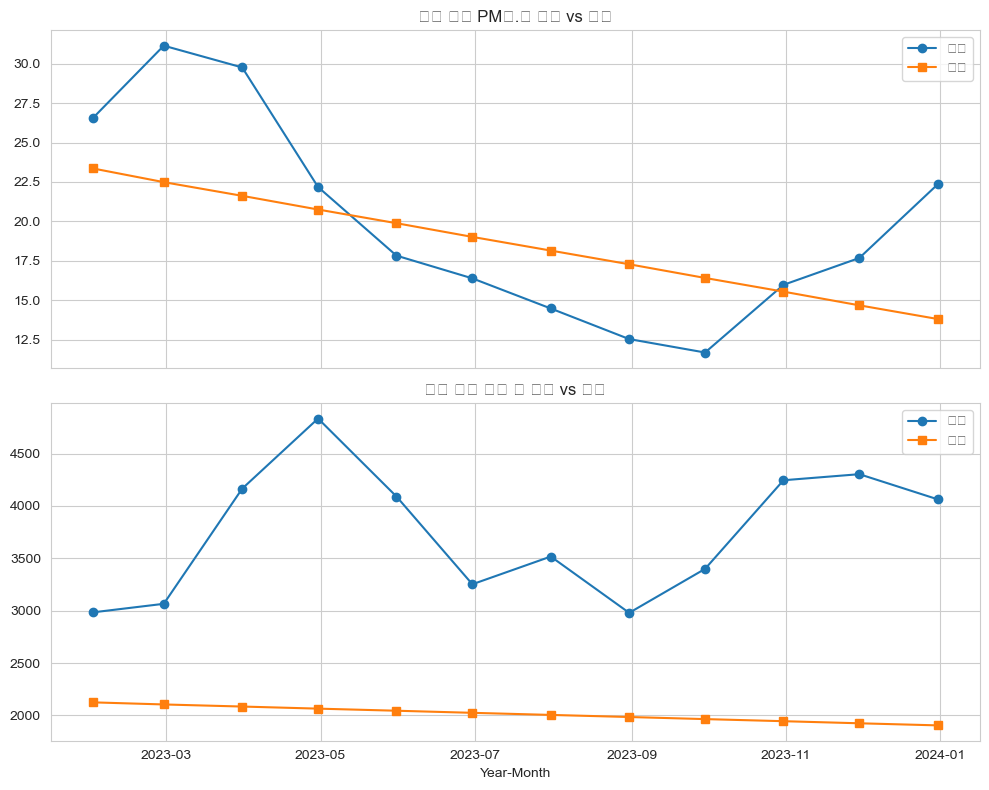

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.font_manager as fm


# 선형회귀로 이번엔 MSE, RMSE(√MSE), R²(score) 전부 구하기 + 시각화

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')

# 1. 데이터 불러오기
asthma_df = pd.read_excel('Asthma_top30_Sum_removed_outliers.xlsx',
                          index_col=0, parse_dates=True)
dust_df   = pd.read_excel('pm25_top30_fixed.xlsx',
                          index_col=0, parse_dates=True)

# 2. 공통 날짜 동기화 및 정렬
common_idx = dust_df.index.intersection(asthma_df.index)
dust_df    = dust_df.loc[common_idx].sort_index()
asthma_df  = asthma_df.loc[common_idx].sort_index()

# 3. 숫자 변환 및 결측치 제거
dust_df    = dust_df.apply(pd.to_numeric, errors='coerce').dropna(how='any')
asthma_df  = asthma_df.apply(pd.to_numeric, errors='coerce').loc[dust_df.index]

# 4. 월별 집계: PM2.5는 평균, 천식환자수는 합계
monthly_pm25   = dust_df.resample('M').mean()
monthly_asthma = asthma_df.resample('M').sum()

# 5. 학습용 피처(연도·월) 생성
monthly_pm25['year']  = monthly_pm25.index.year
monthly_pm25['month'] = monthly_pm25.index.month

X_pm = monthly_pm25[['year','month']]
y_pm = monthly_pm25.drop(columns=['year','month'])
y_as = monthly_asthma

# 6. train/test 분리 (마지막 12개월을 테스트)
train_X_pm = X_pm.iloc[:-12];  test_X_pm = X_pm.iloc[-12:]
train_y_pm = y_pm.iloc[:-12];  test_y_pm = y_pm.iloc[-12:]
train_X_as = train_y_pm        # 천식 예측은 실제 PM2.5 로 학습
train_y_as = y_as.iloc[:-12]
test_y_as  = y_as.iloc[-12:]

# 7. 모델 학습 및 예측
model_pm = LinearRegression().fit(train_X_pm, train_y_pm)
pred_y_pm = pd.DataFrame(
    model_pm.predict(test_X_pm),
    index=test_X_pm.index,
    columns=y_pm.columns
)

model_as = LinearRegression().fit(train_X_as, train_y_as)
pred_y_as = pd.DataFrame(
    model_as.predict(pred_y_pm),
    index=test_X_pm.index,
    columns=y_as.columns
)

# 8. 성능 지표 계산 함수
def performance(true_df, pred_df, name):
    mse = mean_squared_error(true_df, pred_df, multioutput='raw_values')
    rmse = np.sqrt(mse)
    r2 = r2_score(true_df, pred_df, multioutput='raw_values')
    summary = pd.DataFrame({
        'MSE': mse, 
        'RMSE': rmse, 
        'R2': r2
    }, index=true_df.columns)
    print(f"\n=== {name} 예측 성능 ===")
    print("전체 평균 MSE:", mse.mean().round(3), 
          "RMSE:", rmse.mean().round(3), 
          "R2:", r2.mean().round(3))
    display(summary.round(3))

performance(test_y_pm, pred_y_pm,   'PM₂.₅')
performance(test_y_as, pred_y_as,   '천식 환자 수')

# 9. 시각화: “월별 평균(도시 전체) 실제 vs 예측”
avg_true_pm = test_y_pm.mean(axis=1)
avg_pred_pm = pred_y_pm.mean(axis=1)
avg_true_as = test_y_as.mean(axis=1)
avg_pred_as = pred_y_as.mean(axis=1)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axes[0].plot(avg_true_pm.index, avg_true_pm, marker='o', label='실제')
axes[0].plot(avg_pred_pm.index, avg_pred_pm, marker='s', label='예측')
axes[0].set_title('월별 평균 PM₂.₅ 예측 vs 실제')
axes[0].legend()

axes[1].plot(avg_true_as.index, avg_true_as, marker='o', label='실제')
axes[1].plot(avg_pred_as.index, avg_pred_as, marker='s', label='예측')
axes[1].set_title('월별 천식 환자 수 예측 vs 실제')
axes[1].legend()

plt.xlabel('Year-Month')
plt.tight_layout()
plt.show()


# 선형 모델은 예측이이 처참하다.